In [1]:
from paths import *
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble= r'\usepackage{amsfonts}')

In [2]:
def linewidth_from_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.

    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.

    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale linewidth to value range
    return linewidth * (length / value_range)

In [3]:
nrscc = pd.read_pickle(nrscc_path)
dccc = pd.read_pickle(commercial_conditions_path)
chems_pdb = pd.read_pickle(chems_table_from_pdb_path)
chems_dccc = pd.read_pickle(chems_table_from_commercial_screens_path)
pdb_dates = pd.read_pickle(pdb_dates_path)
pdb_conditions = pd.read_pickle(pdb_conditions_path)
dupes = pd.read_pickle(pdb_duplicates_lookup_path)
nrscc_clusters = pd.read_pickle(nrscc_clusters_path)

all_dupes = dupes.copy()
for v in dupes.values():
    all_dupes[v] = v

def resolve_dupes(cond):
    new_cond = []
    for f in cond:
        if f in all_dupes: 
            new_cond.append(all_dupes[f])
        else:
            new_cond.append(f)
    return tuple(sorted(new_cond))

nrscc_all = []
for cluster in nrscc:
    for cond in cluster:
        nrscc_all.append(tuple(sorted(cond)))
        
clusters = {}
for i in range(len(nrscc)):
    cluster = nrscc[i]
    for cond in cluster:
        clusters.setdefault(resolve_dupes(cond), set()).add(i)

In [4]:
linking_table = pd.read_pickle(pdb_commercial_linking_table_path)
np_linking_table = linking_table.to_numpy()
pdb_to_commercial = -1*np.ones(np.max(np_linking_table[:,1])+1, dtype=int)
pdb_to_commercial[np_linking_table[:,1]] = np_linking_table[:,0]
commercial_to_pdb = -1*np.ones(np.max(np_linking_table[:,0])+1, dtype=int)
commercial_to_pdb[np_linking_table[:,0]] = np_linking_table[:,1]

In [5]:
nrscc_filtered = []

# Remove any conditions that are
# -> only composed of a buffer
# -> only one factor with concentration < 0.1 M
# Also, filter by in DCCC
for cond in nrscc_all:
    if -1 in pdb_to_commercial[list(cond)]: # Note: doing this makes no difference, as expected :)
        continue
    if len(cond) == 1:
        details = chems_pdb.iloc[cond[0]]
        if details["buffer"] == "Buffer" or details["molarity"] <= 0.1:
            continue
    nrscc_filtered.append(cond)

c = Counter(nrscc_filtered)
nrscc_sorted = sorted(c, key=lambda x:c[x], reverse=True)

In [6]:
def clusters_in(s):
    out = []
    for cond in s:
        out.extend(clusters[cond])
    return out

In [7]:
sgD = {}
for i in range(1, 6):
    sgD[f"0.{i}"] = np.load(f"generated/screen/Shotgun_II_Greedy_0.{i}.npy", allow_pickle=True)
sgGreedy = np.load("generated/screen/Shotgun_II_Greedy.npy", allow_pickle=True)

In [8]:
chems_pdb.iloc[list(sgD["0.5"][92])]

,name,conc,units,ph,percentage concentration,molarity,ions,buffer
77,glycerol,20.0,v/v,NaN,25.2,27.364535,[],NotBuffer
115,polyethylene glycol 8000,16.0,w/v,NaN,16.0,0.200000,[],NotBuffer
1254,potassium dihydrogen phosphate-dipotassium hyd...,0.8,m,NaN,NaN,0.800000,"[(1, 21), (2, 52), (1, 7), (2, 21), (1, 52), (...",NotBuffer


In [9]:
chems_pdb.iloc[list(sgD["0.5"][92])]["name"].iloc[2]

'potassium dihydrogen phosphate-dipotassium hydrogen phosphate'

In [10]:
conditions_pdb = {}
for pdbid in pdb_conditions:
    cond = resolve_dupes(pdb_conditions[pdbid])
    conditions_pdb.setdefault(cond, []).append(pdbid)

In [11]:
[print(x) for x in conditions_pdb[tuple(sorted(list(sgD["0.5"][92])))]]

3gvh
2w59
5v4e
3gwc
3hzg
3lwa
3n58
2uvl
4jb1
2qhr
5hde
4uvq
4di0


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [12]:
chems_dccc.iloc[pdb_to_commercial[list(sgD["0.5"][92])]]

,name,conc,units,ph,percentage concentration,molarity,ions,buffer
182,glycerol,20.0,v/v,NaN,25.2,27.364535,[],NotBuffer
230,polyethylene glycol 8000,16.0,w/v,NaN,16.0,0.200000,[],NotBuffer
467,potassium dihydrogen phosphate-dipotassium hyd...,0.3,m,NaN,NaN,0.300000,"[(1, 21), (2, 52), (1, 7), (2, 21), (1, 52), (...",NotBuffer


In [13]:
dccc_lookup = {}
for screen in dccc:
    for cond in dccc[screen]:
        k = tuple(sorted(cond))
        dccc_lookup.setdefault(k, list()).append(screen)

In [14]:
tuple(sorted(pdb_to_commercial[list(sgD["0.5"][92])]))

(182, 230, 467)

In [15]:
sgD['0.2']

array([(89, 303, 304), (111,), (22, 66, 208), (89, 100, 303), (39, 89),
       (118, 119), (39, 40, 66), (66, 245), (89, 96, 303),
       (118, 119, 304), (58, 118, 119), (82, 336), (16, 118, 119), (829,),
       (103, 110, 328), (66, 119, 304), (39, 268), (58, 82, 1775),
       (66, 119), (82, 85, 495), (63, 208, 815), (96, 118, 119), (39,),
       (66, 262), (81, 118, 119), (58, 268, 429), (39, 118), (111, 294),
       (71, 168), (66, 328), (66, 105, 1387), (66, 222), (81, 268, 303),
       (268, 1599), (50, 303, 607), (58, 98, 103), (83, 103, 389),
       (66, 153, 282), (111, 584), (58, 66, 119), (89, 304, 328),
       (82, 2896), (89, 119), (66, 96, 119), (66, 90, 304),
       (89, 119, 304), (98, 100, 103), (39, 63, 511), (3895,),
       (66, 170, 858), (111, 378), (103, 173), (152, 1054),
       (63, 321, 624), (66, 85, 154), (268, 451), (910,),
       (118, 197, 2401), (39, 66), (111, 511), (58, 268, 508), (111, 579),
       (16, 66, 119), (66, 81, 119), (27, 328, 389), (16, 39

In [16]:
sgBasic = np.load("generated/screen/Shotgun_II_0.0.npy", allow_pickle=True)

In [17]:
len(set(clusters_in(sgGreedy)))

5465

In [18]:
len(set(clusters_in(sgBasic)))

5448

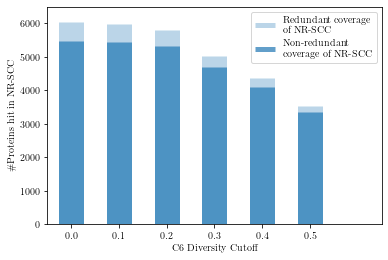

In [19]:
tot = [len(clusters_in(sgGreedy))]
totnr = [len(set(clusters_in(sgGreedy)))]
for k in sgD:
    x0 = len(clusters_in(sgD[k]))
    x1 = len(set(clusters_in(sgD[k])))
    tot.append(x0)
    totnr.append(x1)

x=np.arange(len(tot))
plt.figure()
plt.vlines(x, 0, tot, linewidth=25, alpha=0.3, label="Redundant coverage\nof NR-SCC")
plt.vlines(x, 0, totnr, linewidth=25, alpha=0.7, label="Non-redundant\ncoverage of NR-SCC")
plt.ylim(0, 6500)
plt.xlim(-0.5, 6.5)
plt.xlabel("C6 Diversity Cutoff")
plt.ylabel("\#Proteins hit in NR-SCC")
plt.xticks(np.arange(0, 6), [f"{n:.1f}" for n in np.arange(0, 6)/10])
lgnd = plt.legend()
lgnd.legendHandles[0].set_linewidth(5)
lgnd.legendHandles[1].set_linewidth(5)
plt.savefig("generated/screen/hits.png", dpi=500)
plt.show()

Fraction of clusters (proteins) of SGII0.X that are found in SGII Greedy (SGII0.0)


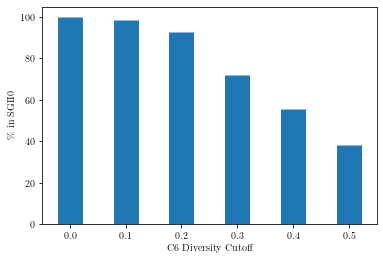

In [20]:
print("Fraction of clusters (proteins) of SGII0.X that are found in SGII Greedy (SGII0.0)")
fracIn0 = [100]
for k in sgD:
    x = len(set(clusters_in(sgGreedy)).intersection(set(clusters_in(sgD[k])))) / len(set(clusters_in(sgGreedy)))
    fracIn0.append(x*100)
    # print("{}: {:.0f}%".format(k,  x* 100))

x=np.arange(len(fracIn0))
plt.figure()
plt.vlines(x, 0, fracIn0, linewidth=25)
plt.xlim(-0.5, 5.5)
plt.ylim(0, 105)
plt.xlabel("C6 Diversity Cutoff")
plt.ylabel("\% in SGII0")
plt.xticks(np.arange(0, 6), [f"{n:.1f}" for n in np.arange(0, 6)/10])
plt.savefig("generated/screen/fracIn0.png", dpi=500)
plt.show()

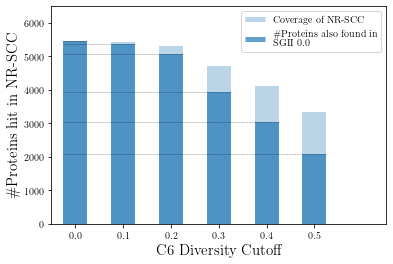

In [24]:
inSg0 = [len(set(clusters_in(sgGreedy)))]
for k in sgD:
    x = len(set(clusters_in(sgGreedy)).intersection(set(clusters_in(sgD[k]))))
    inSg0.append(x)

x=np.arange(len(tot))
fig, ax = plt.subplots()
plt.xlim(-0.5, 6.5)
lw = linewidth_from_data_units(0.5, ax, 'x')
plt.vlines(x, 0, totnr, linewidth=lw, alpha=0.3, label="Coverage of NR-SCC")
plt.vlines(x, 0, inSg0, linewidth=lw, alpha=0.7, label="\#Proteins also found in\nSGII 0.0")
for xv, u in zip(x, inSg0):
    plt.plot([-0.25, xv+0.25], [u,u], c='k', linestyle='--',linewidth=0.5, alpha=0.5)
plt.ylim(0, 6500)
plt.xlabel("C6 Diversity Cutoff", fontsize=15)
plt.ylabel("\#Proteins hit in NR-SCC", fontsize=15)
plt.xticks(np.arange(0, 6), [f"{n:.1f}" for n in np.arange(0, 6)/10])
lgnd = plt.legend()
lgnd.legendHandles[0].set_linewidth(5)
lgnd.legendHandles[1].set_linewidth(5)
plt.savefig("generated/screen/hits.pdf", dpi=90)
plt.show()

In [22]:
totnr

[5465, 5438, 5310, 4708, 4106, 3340]

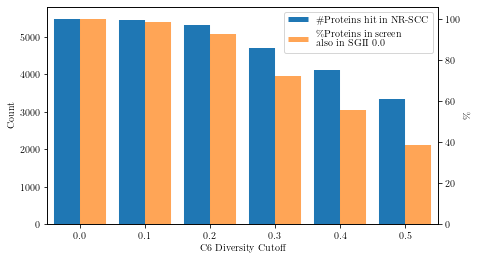

In [39]:
fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()
ax1.set_xlim(-0.5, 5.5)
lw1 = linewidth_from_data_units(0.4, ax1, reference='x')
lns1=ax1.vlines(x-0.2, 0, totnr, linewidth=lw1, alpha=1, colors="tab:blue", label="\#Proteins hit in NR-SCC")
lns2=ax2.vlines(x+0.2, 0, fracIn0, linewidth=lw1, alpha=0.7, colors="tab:orange", label="\%Proteins in screen\nalso in SGII 0.0")
ax1.set_ylim(0, 5800)
ax2.set_ylim(0, 5800/totnr[0]*100)
ax1.set_xlabel("C6 Diversity Cutoff")
ax1.set_ylabel("Count")
ax2.set_ylabel("\%")
plt.xticks(np.arange(0, 6), [f"{n:.1f}" for n in np.arange(0, 6)/10])
lns = [lns1,lns2]
labs = [l.get_label() for l in lns]
lgnd = ax1.legend(lns, labs, loc=0)
lgnd.legendHandles[0].set_linewidth(5)
lgnd.legendHandles[1].set_linewidth(5)
plt.show()

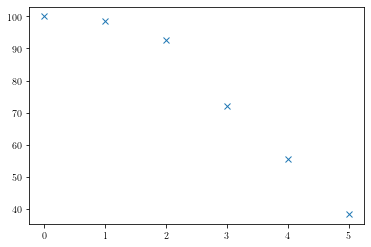

In [9]:
plt.figure()
plt.plot(fracIn0, 'x')


In [10]:
len(set(clusters_in(sgD[0])) ^ set(clusters_in(sgD[1])))

KeyError: 0

In [11]:
len(set(clusters_in(sg00)))

NameError: name 'sg00' is not defined

In [31]:
len(set(clusters_in(sgGreedy)))

5465

In [26]:
len(set(clusters_in_sgOld))

5448

In [17]:
len(set(clusters_in_sgOldUF))

5500

In [21]:
for x in sgOldUF:
    if x not in sgOld:
        print(x)

(207,)
(66,)
(82,)
(89,)


In [23]:
chems_pdb.iloc[66]

name                        sodium hepes
conc                                 0.1
units                                  m
ph                                   7.5
percentage concentration          0.2603
molarity                             0.1
ions                           [(1, 57)]
buffer                            Buffer
Name: 66, dtype: object

In [16]:
sgOldUF = nrscc_sorted[:96]
clusters_in_sgOldUF = []
for cond in sgOldUF:
    clusters_in_sgOldUF.extend(clusters[cond])

In [5]:
sgOld = nrscc_sorted[:96]
clusters_in_sgOld = []
for cond in sgOld:
    clusters_in_sgOld.extend(clusters[cond])

In [9]:
for cond in sgOld:
    if -1 in pdb_to_commercial[list(cond)]:
        print("not found")

In [9]:
# Create Shotgun X

top_clusters= []
remaining = []

# Remove any conditions that are
# -> only composed of a buffer
# -> only one factor with concentration < 0.1 M
# Also, filter by in DCCC
for cond in nrscc_all:
    if -1 in pdb_to_commercial[list(cond)]: # Note: doing this makes no difference, as expected :)
        continue
    if len(cond) == 1:
        details = chems_pdb.iloc[cond[0]]
        if details["buffer"] == "Buffer" or details["molarity"] <= 0.1:
            continue
    remaining.append(cond)

print(f"Removed {len(nrscc_all)-len(remaining)} conditions (either bad or not in DCCC)")

not_covered = set()
for x in remaining:
    not_covered.update(clusters[x])

for i in tqdm(range(96)):
    next_cond = sorted(remaining, key = lambda x: len(set(clusters[x]).intersection(not_covered)), reverse=True)[0]
    next_cluster = clusters[next_cond]
    top_clusters.append(next_cond)
    remaining.remove(next_cond)
    not_covered -= set(next_cluster)

sgx = top_clusters
clusters_in_sgx = []
for cond in sgx:
    clusters_in_sgx.extend(clusters[cond])
print(f"SGII x: {len(set(clusters_in_sgx))} / {len(clusters_in_sgx)} = {100*len(set(clusters_in_sgx))/len(clusters_in_sgx):.1f}% unique")

100%|██████████| 96/96 [00:07<00:00, 12.47it/s]SGII x: 5465 / 6028 = 90.7% unique



In [11]:
sgOld[0]

(89, 303, 304)

In [ ]:
len([x for x in clusters if len(clusters[x]) > 30])

In [ ]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble= r'\usepackage{amsfonts}')

In [ ]:
from maxcov import greedy, bigStepGreedy

In [ ]:
len([x for x in clusters if len(clusters[x]) > 30])

In [ ]:
result = bigStepGreedy(clusters, 96, 4, [x for x in clusters if len(clusters[x]) > 30])
print(result)

In [ ]:
greedySol, greedyCov = greedy(clusters, 96, [x for x in clusters if len(clusters[x]) > 30])

In [ ]:
for cond in greedySol:
    if -1 in pdb_to_commercial[list(cond)]:
        print(cond)

In [ ]:
chems_pdb.iloc[239]

In [ ]:
sg0, sg0cov = greedy(nrscc_all, 96)

In [ ]:
print(f"SGII x: {len(set(clusters_in_sgx))} / {len(clusters_in_sgx)} = {100*len(set(clusters_in_sgx))/len(clusters_in_sgx):.1f}% unique")

In [ ]:
x = list(range(0,6))
y1 = []
y2 = []
for i in x:
    sgn = np.load(f"generated/screen/Shotgun_II_0.{i}.npy", allow_pickle=True)
    clusters_in_sgn = []
    for cond in sgn:
        clusters_in_sgn.extend(clusters[cond])
    y1.append(len(set(clusters_in_sgn)))
    y2.append(len(clusters_in_sgn))
    print(f"SGII 0.{i}: {len(set(clusters_in_sgn))} / {len(clusters_in_sgn)} = {100*len(set(clusters_in_sgn))/len(clusters_in_sgn):.1f}% unique")

In [ ]:
plt.vlines(x, 0, y2, linewidth=25, alpha=0.3, label="Redundant coverage\nof NR-SCC")
plt.vlines(x, 0, y1, linewidth=25, alpha=0.7, label="Non-redundant\ncoverage of NR-SCC")
plt.ylim(0, 6500)
plt.xlim(-0.5, 6.5)
plt.xlabel("C6 Diversity Cutoff")
plt.ylabel("\#Proteins hit in NR-SCC")
plt.xticks(np.arange(0, 6), [f"{n:.1f}" for n in np.arange(0, 6)/10])
lgnd = plt.legend()
lgnd.legendHandles[0].set_linewidth(5)
lgnd.legendHandles[1].set_linewidth(5)
plt.savefig("generated/screen/hits.png", dpi=500)
plt.show()

In [ ]:
from scipy.special import comb

In [ ]:
comb(len(nrscc), 96)

In [ ]:
sg0 = np.load(f"generated/screen/Shotgun_II_0.0.npy", allow_pickle=True)

In [ ]:
conds = set(sg0) - set(sgx) # in sg0 and not in sgx
for c in conds:
    print("="*80)
    print(chems_pdb.iloc[list(c)][['name','conc','units','ph']])

In [ ]:
conds = set(sgx) - set(sg0) # in sgx and not in sg0
for c in conds:
    print("="*80)
    print(chems_pdb.iloc[list(c)][['name','conc','units','ph']])

In [ ]:
sg_nodccc = nrscc_sorted[:96]

In [ ]:
(63,81,303) in nrscc_sorted

In [ ]:
pdb_to_commercial[[63,81,303]]

In [ ]:
conds = set(sg_nodccc) - set(sg0) # in sg with no dccc and not in sg from dccc
for c in conds:
    print("="*80)
    print(chems_pdb.iloc[list(c)][['name','conc','units','ph']])

    # why does (63,81,303) not appear in DCCC? It is A9 in Hampton Crystal Screen HT
    # it is in the DCCC
    # so why does it not appear in the screen with DCCC filtering...

In [ ]:
sg_nodccc.index((63,81,303))
sg_nodccc[83]

In [ ]:
conds = set(sg0) - set(sg_nodccc) # in sg from dccc and not in sg with no dccc
for c in conds:
    print("="*80)
    print(chems_pdb.iloc[list(c)][['name','conc','units','ph']])